# Visualize the linear model coefficients as scatter plots


## Import libraries


In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


## Set paths and load in TSV


In [2]:
# path to tsv with LM coefficients
lm_results_dir <- file.path("./results")
lm_file <- file.path(lm_results_dir, "./linear_model_cp_features_plate1.tsv")

# save path for figure
lm_fig_dir <- file.path("./figures")
lm_fig <- file.path(lm_fig_dir, "linear_model_cp_features_plate1.png")

# Load and process linear model data
lm_df <- readr::read_tsv(
    lm_file,
    col_types = readr::cols(.default = "d", feature = "c")
)

print(dim(lm_df))
head(lm_df)


[1] 1731    5


feature,r2_score,cell_count_coef,Null_coef,WT_coef
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cytoplasm_AreaShape_Area,0.389572936,-0.017550700,-0.336014311,0.336014311
Cytoplasm_AreaShape_BoundingBoxArea,0.377129989,-0.020594709,-0.243760036,0.243760036
Cytoplasm_AreaShape_BoundingBoxMaximum_X,0.001273655,-0.000678252,-0.026804703,0.026804703
Cytoplasm_AreaShape_BoundingBoxMaximum_Y,0.005930619,0.000715508,-0.096230103,0.096230103
Cytoplasm_AreaShape_BoundingBoxMinimum_X,0.008106605,0.003740672,0.014582643,-0.014582643
Cytoplasm_AreaShape_BoundingBoxMinimum_Y,0.026489120,0.007645777,-0.003374704,0.003374704


## Clean up the data frame for visualization


In [3]:
# Arrange by absolute value coefficient
# Split out components of feature name for visualization
lm_df <- lm_df %>%
    dplyr::arrange(desc(abs(Null_coef))) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel",
            "parameter1",
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

# Clean channel for visualization and interpretation
lm_df$channel_cleaned <-
    dplyr::recode(
        lm_df$channel_cleaned,
        "DAPI" = "nuclei",
        "GFP" = "ER",
        "RFP" = "actin",
        .default = "other",
        .missing = "other"
    )

print(dim(lm_df))
head(lm_df, 10)


Warning message:
“Expected 6 pieces. Additional pieces discarded in 468 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 723 rows [34, 35, 47, 51,
63, 66, 68, 72, 73, 74, 76, 79, 81, 83, 88, 89, 94, 99, 100, 105, ...].”


[1] 1731   12


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,r2_score,cell_count_coef,Null_coef,WT_coef,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cells_Texture_SumEntropy_GFP_3_02_256,Cells,Texture,SumEntropy,GFP,3,02,0.2074251,-0.007895167,0.6145610,-0.6145610,ER
Cells_Texture_SumEntropy_GFP_3_03_256,Cells,Texture,SumEntropy,GFP,3,03,0.2036442,-0.008115417,0.6121762,-0.6121762,ER
Cells_Texture_SumEntropy_GFP_3_00_256,Cells,Texture,SumEntropy,GFP,3,00,0.2053192,-0.007834732,0.6112067,-0.6112067,ER
Cells_Texture_SumEntropy_GFP_3_01_256,Cells,Texture,SumEntropy,GFP,3,01,0.2025519,-0.008142424,0.6110672,-0.6110672,ER
Cells_Texture_AngularSecondMoment_GFP_3_02_256,Cells,Texture,AngularSecondMoment,GFP,3,02,0.2601552,0.001782800,-0.5947110,0.5947110,ER
Cells_Texture_AngularSecondMoment_GFP_3_00_256,Cells,Texture,AngularSecondMoment,GFP,3,00,0.2536100,0.002067132,-0.5918340,0.5918340,ER
Cytoplasm_Texture_AngularSecondMoment_GFP_3_02_256,Cytoplasm,Texture,AngularSecondMoment,GFP,3,02,0.2641807,0.001286384,-0.5914474,0.5914474,ER
Cells_Texture_AngularSecondMoment_GFP_3_01_256,Cells,Texture,AngularSecondMoment,GFP,3,01,0.2531856,0.002016927,-0.5906073,0.5906073,ER
Cells_Texture_AngularSecondMoment_GFP_3_03_256,Cells,Texture,AngularSecondMoment,GFP,3,03,0.2602418,0.001495697,-0.5904066,0.5904066,ER


## Visualize LM as scatter plot


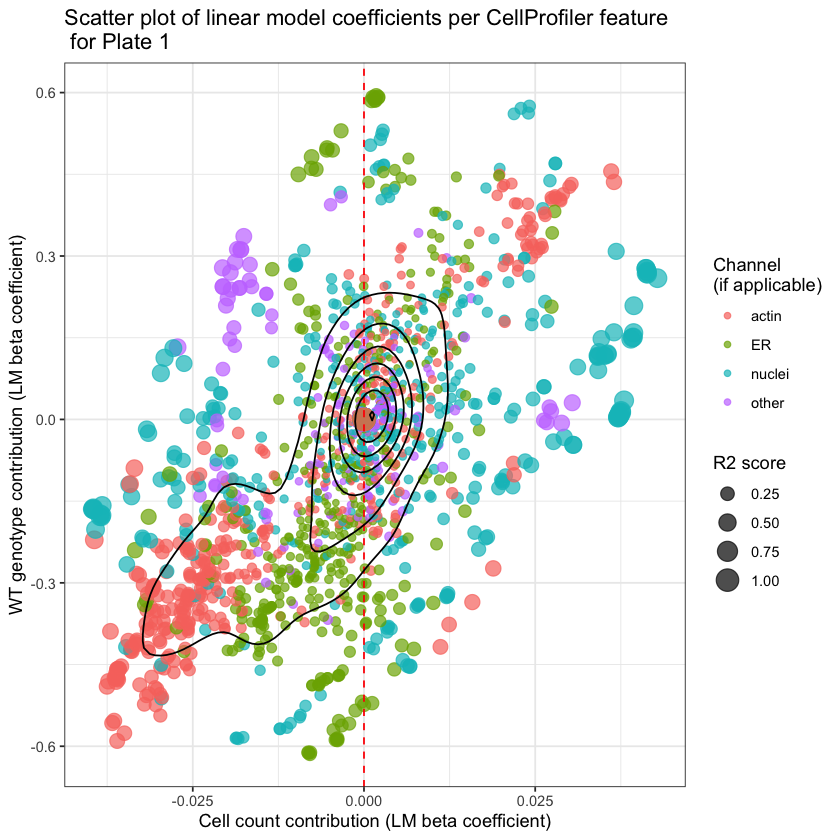

In [4]:
# Specify order so that the organelles match the correct color (red, green, blue)
color_order <- c("actin", "ER", "nuclei", "other")

# Plot the linear model coefficients for the WT genotype contribution
# Positive coeff = more likely to be WT cell if feature increases
# Negative coeff = more likely to be Null cell if feature increases
lm_fig_gg <- (
    ggplot(lm_df, aes(x = cell_count_coef, y = WT_coef))
    +
        geom_point(aes(size = r2_score, color = factor(channel_cleaned, levels = color_order)), alpha = 0.7)
        +
        geom_vline(xintercept = 0, linetype = "dashed", color = "red")
        +
        geom_density2d(color = "black", show.legend = FALSE)
        +
        theme_bw()
        +
        guides(
            color = guide_legend(title = "Channel\n(if applicable)", order = 1),
            size = guide_legend(title = "R2 score")
        )
        +
        ylab("WT genotype contribution (LM beta coefficient)")
        +
        xlab("Cell count contribution (LM beta coefficient)")
        +
        ggtitle("Scatter plot of linear model coefficients per CellProfiler feature\n for Plate 1") # nolint
)

# Output figure
ggsave(lm_fig, lm_fig_gg, dpi = 500, height = 6, width = 6)

lm_fig_gg
